<a href="https://colab.research.google.com/github/mendiang/IYKRA-Data-Science-Fellowship-Batch-6/blob/main/Machine_Learning_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Practice Case - Machine Learning
####Imam Mukhri
####Data Fellowship Batch 6 IYKRA

#1. Import Data


#1.1 Import Library

In [1]:
%pip install mlxtend --upgrade

Requirement already up-to-date: mlxtend in /usr/local/lib/python3.7/dist-packages (0.18.0)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import matplotlib.cm as cm
import numpy as np
import plotly.graph_objs as go
import plotly as py

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

#1.2 Importing Datasets

In [3]:
data_raw = pd.read_excel('ML_2_Fellow.xls')
data_raw.head()

,Kode_Bayar,Kode_Barang,Barang,Jumlah,Tanggal_Transaksi,Harga_Satuan,Kode_Pelanggan,Negara
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data_raw.tail()

,Kode_Bayar,Kode_Barang,Barang,Jumlah,Tanggal_Transaksi,Harga_Satuan,Kode_Pelanggan,Negara
65530,541696,21205,MULTICOLOUR 3D BALLS GARLAND,1.0,1/20/2011 18:08,2.46,NaN,United Kingdom
65531,541696,21208,PASTEL COLOUR HONEYCOMB FAN,2.0,1/20/2011 18:08,1.63,NaN,United Kingdom
65532,541696,21209,MULTICOLOUR HONEYCOMB FAN,1.0,1/20/2011 18:08,1.63,NaN,United Kingdom
65533,541696,21212,PACK OF 72 RETROSPOT CAKE CASES,1.0,1/20/2011 18:08,1.25,NaN,United Kingdom
65534,541696,21217,RED RETROSPOT ROUND CAKE TINS,1.0,1/20/2011 18:08,20.79,NaN,United Kingdom


In [5]:
print("Rows: %d and Columns: %d \n" %data_raw.shape)

Rows: 65535 and Columns: 8 



#2. Data Preprocessing

####Data Description



* Kode_Bayar: Pengidentifikasian unik untuk faktur. Nomor faktur yang terdapat di beberapa baris mengartikan transaksi tersebut dilakukan dalam satu faktur (beberapa pembelian).
* Kode_Barang: Pengidentifikasian item yang terkandung dalam faktur.
* Barang: Deskripsi tekstual dari masing-masing item stok.
* Jumlah: Jumlah barang yang dibeli.
* Tanggal_Transaksi: Tanggal pembelian.
* Harga_Satuan : Patokan harga
* Kode_Pelanggan: ID untuk pelanggan yang melakukan pembelian.
* Negara: Negara pelanggan.



In [6]:
# Create a duplicate dataset
data = data_raw.copy()

#2.1 Check for Missing Value


In [7]:
# Checking for missiing data
data.isnull().sum()

Kode_Bayar               0
Kode_Barang           1059
Barang                1225
Jumlah                1059
Tanggal_Transaksi     1059
Harga_Satuan          1059
Kode_Pelanggan       25782
Negara                1059
dtype: int64

In [8]:
# Drop null values
data = data.dropna()
data.isnull().sum()

Kode_Bayar           0
Kode_Barang          0
Barang               0
Jumlah               0
Tanggal_Transaksi    0
Harga_Satuan         0
Kode_Pelanggan       0
Negara               0
dtype: int64

In [9]:
print("Rows: %d and Columns: %d \n" %data.shape)

Rows: 39753 and Columns: 8 



#2.2 Check for Data Types

In [10]:
# Checking for Data Types
data.dtypes

Kode_Bayar            object
Kode_Barang           object
Barang                object
Jumlah               float64
Tanggal_Transaksi     object
Harga_Satuan         float64
Kode_Pelanggan       float64
Negara                object
dtype: object

In [11]:
# Changing Data Types of CustomerID
data = data.astype({"Jumlah": int, "Kode_Pelanggan": object})
data['Tanggal_Transaksi'] = pd.to_datetime(data['Tanggal_Transaksi'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39753 entries, 0 to 65101
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Kode_Bayar         39753 non-null  object        
 1   Kode_Barang        39753 non-null  object        
 2   Barang             39753 non-null  object        
 3   Jumlah             39753 non-null  int64         
 4   Tanggal_Transaksi  39753 non-null  datetime64[ns]
 5   Harga_Satuan       39753 non-null  float64       
 6   Kode_Pelanggan     39753 non-null  object        
 7   Negara             39753 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 2.7+ MB


#2.3 Check Numerical Data

In [12]:
# Describe numerical data
data.describe()

,Jumlah,Harga_Satuan
count,39753.000000,39753.000000
mean,11.896410,3.238465
std,530.766562,8.230895
min,-74215.000000,0.000000
25%,2.000000,1.250000
50%,4.000000,2.100000
75%,12.000000,3.750000
max,74215.000000,1126.000000


In [13]:
# Exclude Jumlah and Harga_Satuan column with negative quantity
data = data[data['Jumlah']>0]
data = data[data['Harga_Satuan']>0]
data.describe()

,Jumlah,Harga_Satuan
count,38724.000000,38724.000000
mean,14.600170,3.141287
std,380.277513,5.274975
min,1.000000,0.070000
25%,2.000000,1.250000
50%,5.000000,2.100000
75%,12.000000,3.750000
max,74215.000000,295.000000


In [14]:
print("Rows: %d and Columns: %d \n" %data.shape)

Rows: 38724 and Columns: 8 



#3. Data Exploration
##Question Number 1
What items customers buy the most and are there any items we should ignore?

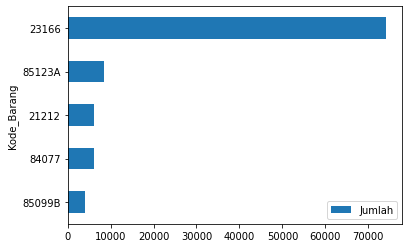

In [15]:
# Top 5 best sold item  
top_5 = data.groupby(['Kode_Barang']).sum().sort_values(by='Jumlah',ascending=False).head(5)
top_sold = top_5.plot.barh(y='Jumlah')
top_sold.invert_yaxis()

In [42]:
get_product_desc(data,23166)

23166 is MEDIUM CERAMIC TOP STORAGE JAR


##Question Number 2
What is our strategy to increase sales based on our export destination countries?

[Text(0, 0.5, 'Jumlah'),
 Text(0.5, 0, 'Negara'),
 Text(0.5, 1.0, 'Top 5 Countries with the Highest Item Sales')]

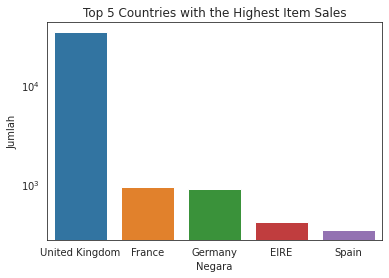

In [16]:
# Plot top 5 countries having highest product sales
sns.set_style("white")
g = sns.countplot(x="Negara",data=data, order=data.Negara.value_counts().iloc[:5].index)
g.set_yscale("log")
g.set(xlabel='Negara', ylabel='Jumlah', title="Top 5 Countries with the Highest Item Sales")

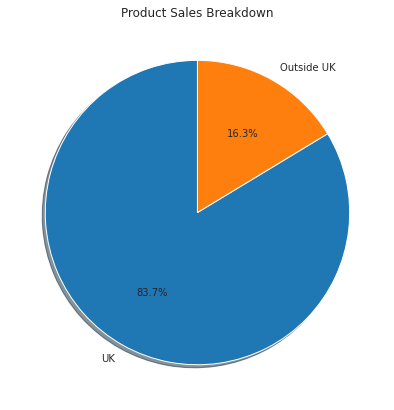

In [17]:
# Explore product sales breakdown from the UK and outside the UK.
data['Internal'] = data.Negara.apply(lambda x: 'UK' if x=='United Kingdom' else 'Outside UK' )
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(122)
market = data.groupby(["Internal"])['Jumlah'].sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Product Sales Breakdown')
plt.show()

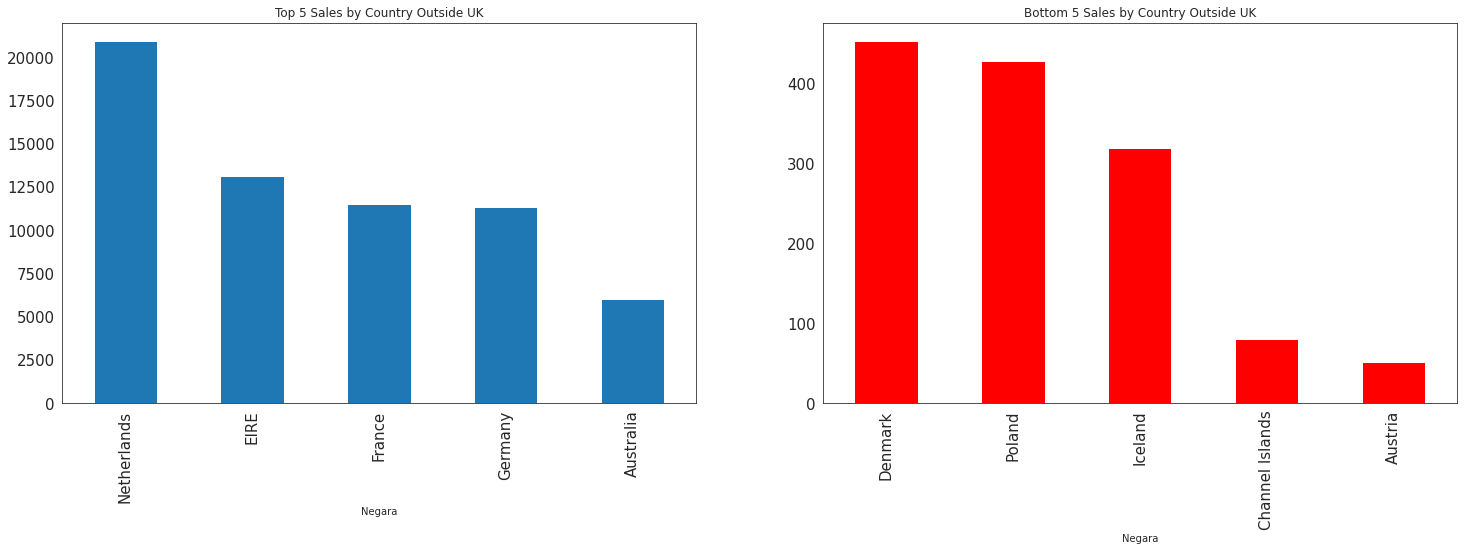

In [18]:
#Top and worst country outside UK according to product sales
Outside_UK = data[data.Negara!='United Kingdom']

fig = plt.figure(figsize=(25, 7))

f1 = fig.add_subplot(121)
Non_UK_top5 = Outside_UK.groupby(["Negara"])['Jumlah'].sum().sort_values(ascending = False).head(5)
Top_Non_UK = Non_UK_top5.plot(kind='bar', title='Top 5 Sales by Country Outside UK', 
                                   fontsize = 15) 

f2 = fig.add_subplot(122)
Non_UK_bottom5 = Outside_UK.groupby(["Negara"])['Jumlah'].sum().sort_values(ascending 
                                                                                   = False).tail(5)
Worst_Non_UK = Non_UK_bottom5.plot(kind='bar', title='Bottom 5 Sales by Country Outside UK', 
                                   color='red', fontsize = 15)

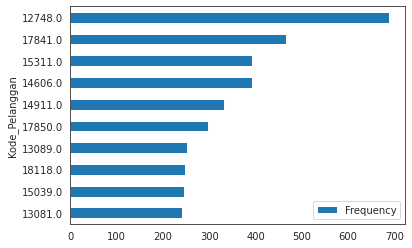

In [19]:
# top 10 loyal customers based on buying frequency
freq_data = data
freq_data['Frequency'] = 1
freq_data = freq_data.groupby(['Kode_Pelanggan']).sum().sort_values(by='Frequency',
                                                                    ascending=False).head(10)
ax = freq_data.plot.barh(y='Frequency')
ax.invert_yaxis()

#4. Modelling
##Question Number 3
Do customer segmentation appropriately. Please explain in detail and completely

#4.1 Feature Engineering

In [20]:
# Create Recency Variable
data['Revenue'] = data['Jumlah']*data['Harga_Satuan']
ref_date = data.Tanggal_Transaksi.max() + datetime.timedelta(days=1)
print('Reference Date:', ref_date)
data['Recency'] = (ref_date - data.Tanggal_Transaksi).astype('timedelta64[D]')

# Aggregate data by each customer
custdf = data.groupby(['Kode_Pelanggan']).agg({
    'Tanggal_Transaksi': lambda x: (ref_date - x.max()).days,
    'Kode_Pelanggan': 'count',
    'Revenue': 'sum'})

# Rename columns
custdf.rename(columns = {'Tanggal_Transaksi': 'Recency',
                          'Kode_Pelanggan': 'Frequency',
                          'Revenue': 'MonetaryValue'}, inplace=True)

Reference Date: 2011-12-02 16:57:00


In [21]:
# Resulting Data Frame
custdf

,Recency,Frequency,MonetaryValue
Kode_Pelanggan,,,
12346.0,318,1,77183.60
12347.0,508,31,711.79
12348.0,350,17,892.80
12356.0,318,36,2271.62
12359.0,1,14,530.70
...,...,...,...
18245.0,348,25,355.65
18259.0,477,7,376.30
18260.0,92,37,787.77


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Skewness: -0.00026880666638761703
Kurtosis: -0.3651267510579146


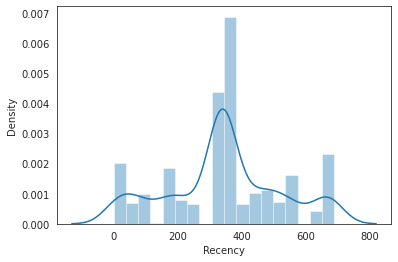

In [22]:
# Check Recency distribution
sns.distplot(custdf['Recency'])
print('Skewness:',custdf['Recency'].skew())
print('Kurtosis:',custdf['Recency'].kurt())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Skewness: 5.625182425580154
Kurtosis: 55.487317144622146


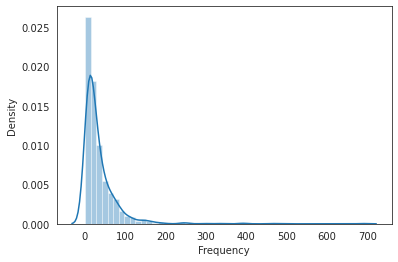

In [23]:
# Check Frequency distribution
sns.distplot(custdf['Frequency'])
print('Skewness:',custdf['Frequency'].skew())
print('Kurtosis:',custdf['Frequency'].kurt())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Skewness: 17.06270671133784
Kurtosis: 387.3493895368363


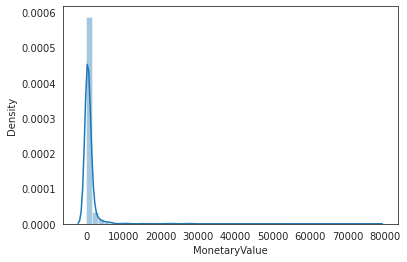

In [24]:
# Check MonetaryValue distribution
sns.distplot(custdf['MonetaryValue'])
print('Skewness:',custdf['MonetaryValue'].skew())
print('Kurtosis:',custdf['MonetaryValue'].kurt())

#4.2 Data Preprocessing

In [25]:
# Log transforming the data Frequency_log & MonetaryValue_log to make them normal distribution
custdf['Frequency_log'] = custdf['Frequency'].apply(math.log)
custdf['MonetaryValue_log'] = custdf['MonetaryValue'].apply(math.log)
feature_vector = ['MonetaryValue_log', 'Frequency_log', 'Recency']

# Scaling the data
cust_subset = custdf[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(cust_subset)
cust_scaled = scaler.transform(cust_subset)
pd.DataFrame(cust_scaled, columns=cust_subset.columns).describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
MonetaryValue_log,1138.0,0.0,1.0,-5.86,-0.63,-0.12,0.56,5.04
Frequency_log,1138.0,-0.0,1.0,-2.59,-0.57,0.04,0.70,3.14
Recency,1138.0,-0.0,1.0,-1.93,-0.55,0.04,0.58,1.95


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



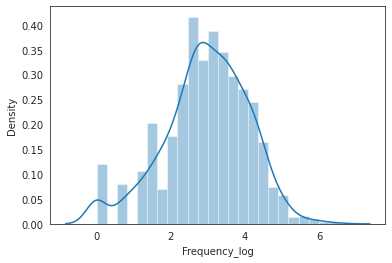

In [26]:
sns.distplot(custdf['Frequency_log'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



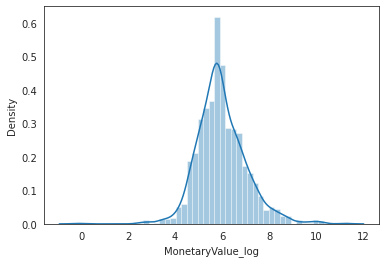

In [27]:
sns.distplot(custdf['MonetaryValue_log'])

#4.2 K - Means

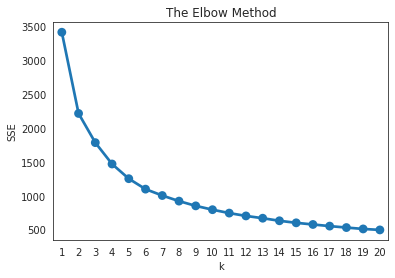

In [28]:
#Finding ideal number of cluster
sse = {}
cl = 20

for k in range(1, cl+1):
    # Create a kmeans model on our data, using k clusters.
    kmeans = KMeans(n_clusters=k, init='k-means++', 
                    n_init=10,
                    max_iter=300,
                    tol=1e-04,
                    random_state=101)
    # Fit the KMeans Algo to our data
    kmeans.fit(cust_scaled)
    # SSE to closest cluster centroid
    sse[k] = kmeans.inertia_

#Plot the Elbow Method Graph
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

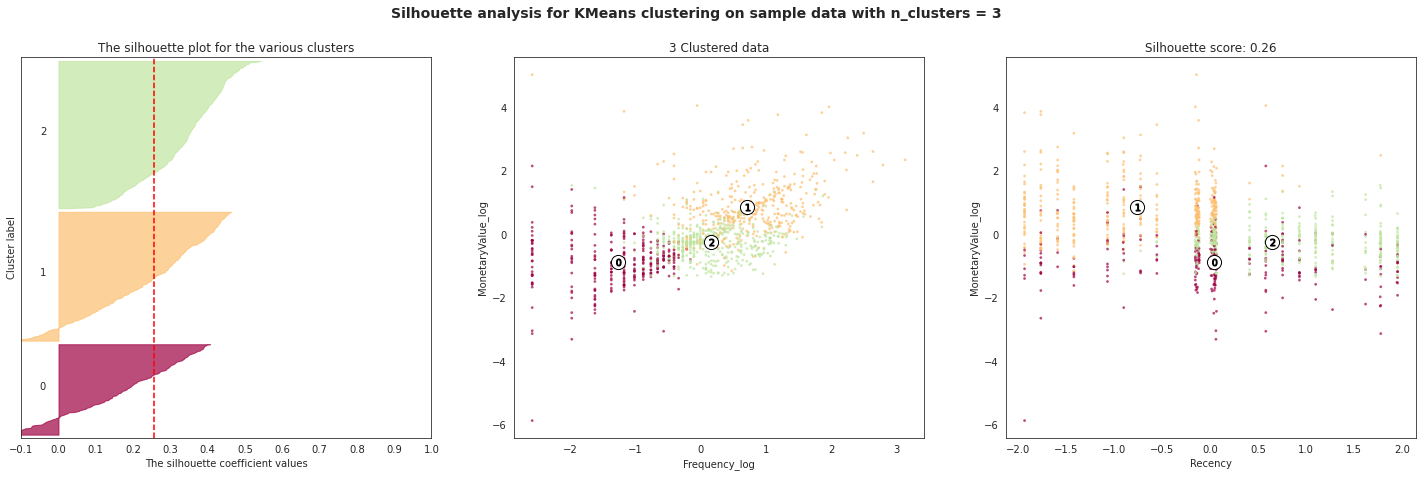

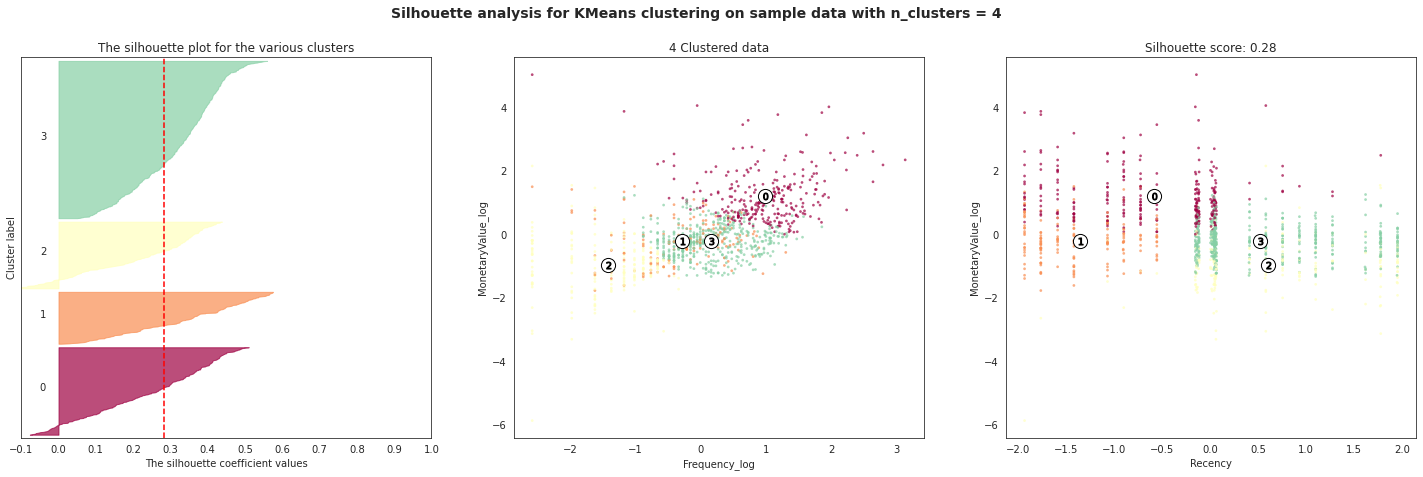

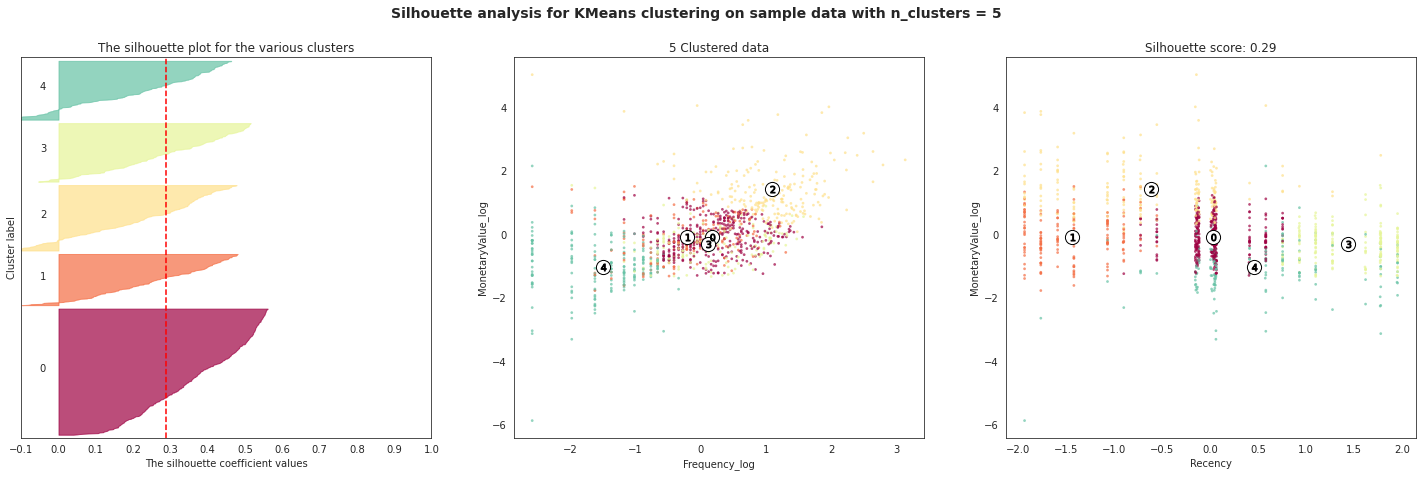

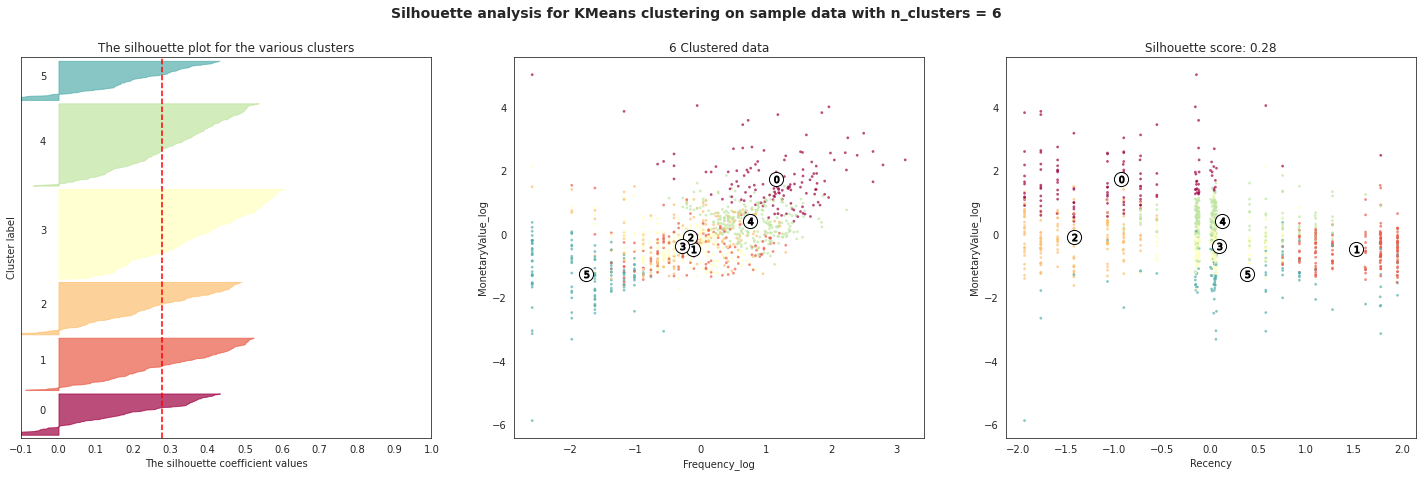

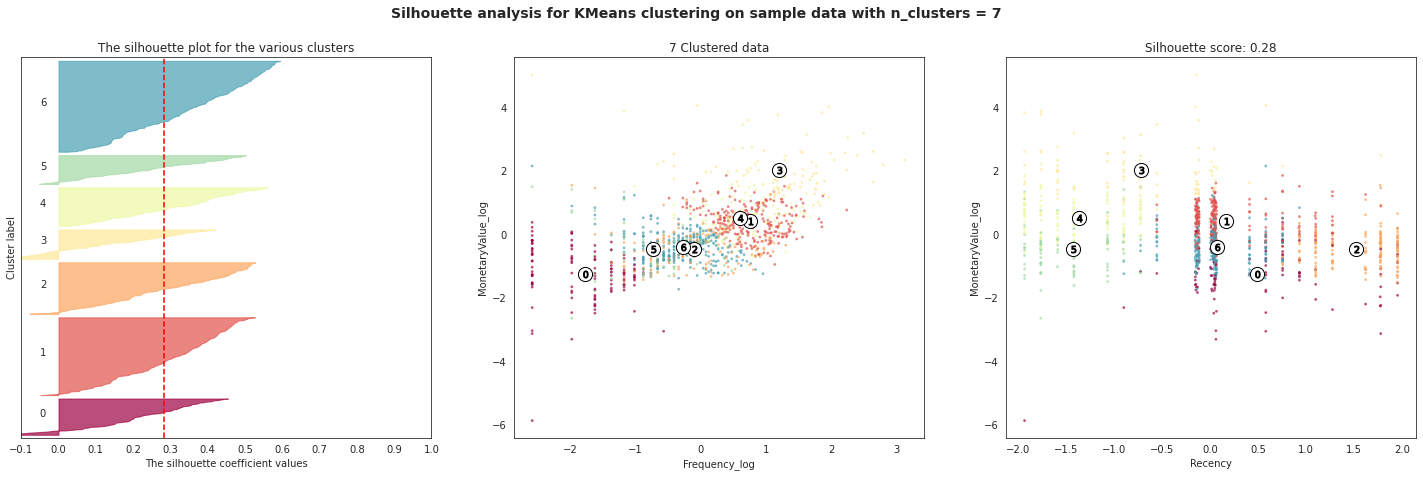

In [29]:
#Using silhouette analysis to evaluate and determine the optimal Elbow Method result.
cluster_centers = dict()
X_scaled = cust_scaled

for n_clusters in range(3,8,1):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

In [30]:
# Check at the cluster center values after returning them to normal values from the log and scaled version.
features = ['MonetaryValue',  'Recency',  'Frequency']
for i in range(3,8,1):
    print("for {} clusters the silhouette score is {:1.4f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.2573
Centers of each cluster:
   MonetaryValue    Recency      Frequency
0     160.417293   4.507957  1.220471e+152
1     994.482679  43.142283   1.722408e+90
2     304.660489  23.025489  2.063322e+198
--------------------------------------------------
for 4 clusters the silhouette score is 0.2830
Centers of each cluster:
   MonetaryValue    Recency      Frequency
0    1414.965409  58.711144  1.288886e+104
1     319.776821  13.735682   8.346470e+44
2     142.288681   3.769981  1.127845e+195
3     317.984705  22.912938  1.416236e+189
--------------------------------------------------
for 5 clusters the silhouette score is 0.2878
Centers of each cluster:
   MonetaryValue    Recency      Frequency
0     357.969520  23.246625  2.336593e+151
1     357.873532  14.973228   4.489613e+38
2    1765.759362  66.590067  2.130195e+101
3     284.069627  21.661219  2.654900e+259
4     134.536837   3.469822  1.413188e+184
----------------------------------------

In [31]:
#Evaluate using Box Plot on the 3 clusters in each feature.
x_data = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
cutoff_quantile = 95
custdf['clusters_3'] = cluster_centers[3]['labels'] 
clusters = [3]

for n_clusters in clusters:
    cl = 'clusters_' + str(n_clusters)
    for fild in range(0, 3):
        field_to_plot = features[fild]        
        y_data = list()
        ymax = 0
        for i in np.arange(0,n_clusters):
            y0 = custdf[custdf[cl]==i][field_to_plot].values
            y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
            if ymax < max(y0): ymax = max(y0)
            y_data.insert(i, y0)

        traces = []

        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
                traces.append(go.Box(y=yd, name=xd, boxpoints=False, jitter=0.5, whiskerwidth=0.2, fillcolor=cls,
                    marker=dict( size=1, ),
                    line=dict(width=1),
                ))
        
        layout = go.Layout(
            title='Differences in {} with {} Clusters and {:1.2f} Score'.\
            format(field_to_plot, n_clusters, cluster_centers[n_clusters]['silhouette_score']),
            yaxis=dict( autorange=True, showgrid=True, zeroline=True,
                dtick = int(ymax/10),
                gridcolor='black', gridwidth=0.1, zerolinecolor='rgb(255, 255, 255)', zerolinewidth=2, ),
            margin=dict(l=40, r=30, b=50, t=50, ),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )

        fig = go.Figure(data=traces, layout=layout)
        py.offline.iplot(fig)

#4.3 Apriori Algorithm

##Question Number 4
Get the hidden insight from the data

In [32]:
#Finding hidden insight on the itemset which mostly bought at the same time. 

# Encoding
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1
    
# Get product name by using StockCode
def get_product_desc(new_df, stockCode):
    print(stockCode,"is",new_df.loc[new_df["Kode_Barang"]==stockCode,"Barang"].values[0])
    
# Analysis function
def market_analysis(new_df,negara,support,mode):
    # Create new dataframe
    basket = (new_df.loc[new_df['Negara'] ==negara] 
              .groupby(['Kode_Bayar', 'Kode_Barang'])['Jumlah'] 
              .sum().unstack().reset_index().fillna(0) 
              .set_index('Kode_Bayar')) 
    
    # Encoding the datasets 
    basket_encoded = basket.applymap(hot_encode) 
    
    # Building the model. Choose between apriori or fpgrowth
    if mode=="fpgrowth":
        frq_items = fpgrowth(basket_encoded, min_support = support, use_colnames = True) 
    elif mode=="apriori":
        frq_items = apriori(basket_encoded, min_support = support, use_colnames = True) 

    # Collecting the inferred rules in a dataframe 
    rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
    rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
    
    return rules

Association rules are created by searching data for frequent if-then patterns and using the criteria support and confidence to identify the most important relationships.Support is an indication of how frequently the items appear in the data. Confidence indicates the number of times the if-then statements are found true. A third metric, called lift, can be used to compare confidence with expected confidence, or how many times an if-then statement is expected to be found true.

In [33]:
# Create ruleset on UK market
apriori_UK = market_analysis(data,"United Kingdom", 0.025, "apriori")

In [34]:
apriori_UK.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
31,(82486),(82483),0.043908,0.047750,0.027442,0.625000,13.089080,0.025346,2.539334
30,(82483),(82486),0.047750,0.043908,0.027442,0.574713,13.089080,0.025346,2.248109
21,(22727),(22726),0.051043,0.055982,0.036773,0.720430,12.868859,0.033915,3.376678
20,(22726),(22727),0.055982,0.051043,0.036773,0.656863,12.868859,0.033915,2.765532
19,(22722),(22720),0.037870,0.056531,0.027442,0.724638,12.818348,0.025302,3.426281
18,(22720),(22722),0.056531,0.037870,0.027442,0.485437,12.818348,0.025302,1.869799
27,(82482),(82494L),0.049396,0.058178,0.035675,0.722222,12.414046,0.032801,3.390560
26,(82494L),(82482),0.058178,0.049396,0.035675,0.613208,12.414046,0.032801,2.457658
10,(22112),(22835),0.072448,0.045005,0.027442,0.378788,8.416482,0.024182,1.537308
11,(22835),(22112),0.045005,0.072448,0.027442,0.609756,8.416482,0.024182,2.376852


In [35]:
apriori_UK.shape

(38, 9)

In [36]:
# Create transaction dataset from UK only
UK_products_df = data.loc[data["Negara"]=="United Kingdom"]

In [37]:
# Get product name based on StockCode
get_product_desc(UK_products_df, 82486)
get_product_desc(UK_products_df, 82483)
get_product_desc(UK_products_df, 22469)
get_product_desc(UK_products_df,"85123A")

82486 is WOOD S/3 CABINET ANT WHITE FINISH
82483 is WOOD 2 DRAWER CABINET WHITE FINISH
22469 is HEART OF WICKER SMALL
85123A is WHITE HANGING HEART T-LIGHT HOLDER


In [38]:
# Get ruleset where confidence is more than 0.4 and sort by support
apriori_UK.loc[apriori_UK["confidence"]>0.4].sort_values("support",ascending=True).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
32,(82494L),(85123A),0.058178,0.162459,0.025796,0.443396,2.729284,0.016344,1.504735
34,(84029G),(84029E),0.058178,0.056531,0.026345,0.452830,8.010258,0.023056,1.724270
35,(84029E),(84029G),0.056531,0.058178,0.026345,0.466019,8.010258,0.023056,1.763776
24,(22960),(22961),0.052689,0.068606,0.026345,0.500000,7.288000,0.022730,1.862788
28,(82482),(85123A),0.049396,0.162459,0.026894,0.544444,3.351276,0.018869,1.838505


In [39]:
# Get product name by StockCode
get_product_desc(UK_products_df,"82494L")
get_product_desc(UK_products_df,"85123A")

82494L is WOODEN FRAME ANTIQUE WHITE 
85123A is WHITE HANGING HEART T-LIGHT HOLDER


In [40]:
# Model Evaluation
# Check whether lift value is over than 1
def check_lift_over_than_1(rule):
    count_invalid_ruleset = 0
    
    # Iterate over rows
    for index,row in rule.iterrows():
        
        #if lift value is below than 1, increment count_invalid_ruleset variable
        if row["lift"]<1:
            count_invalid_ruleset += 1
    
    # if count_invalid_ruleset is 0, print that the ruleset are all valid
    if count_invalid_ruleset == 0:
        print("All the ruleset are valid")
        
    # else, print that there are some invalid ruleset
    else:
        print("Some of the ruleset are invalid")
        print("There are",count_invalid_ruleset,"invalid ruleset")
        
    # print average lift from the whole ruleset
    print("Average lift :",rule["lift"].mean())

In [41]:
check_lift_over_than_1(apriori_UK)

All the ruleset are valid
Average lift : 6.754915867391074
